In [41]:
from PIL import Image
import numpy as np
import os
from keras.models import load_model, Model
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [3]:
model = load_model("alexnet.h5")
model.compile()

In [26]:
gear_defects = [0, 35, 76, 77]
defect_dict = {0:0, 1:35, 2:76, 3:77}

In [4]:
# Find location of each filter layer
for i in range(len(model.layers)):
    layer = model.layers[i]
    # Check for convolutional layer
    if 'conv' not in layer.name:
        continue
        # Summarize output shape
    print(i, layer.name, layer.output.shape)

0 conv2d_25 (None, 73, 98, 64)
3 conv2d_26 (None, 36, 48, 128)
6 conv2d_27 (None, 17, 23, 256)
7 conv2d_28 (None, 17, 23, 256)
8 conv2d_29 (None, 17, 23, 128)


In [5]:
# Define specific filter layer
filters, biases = model.layers[6].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

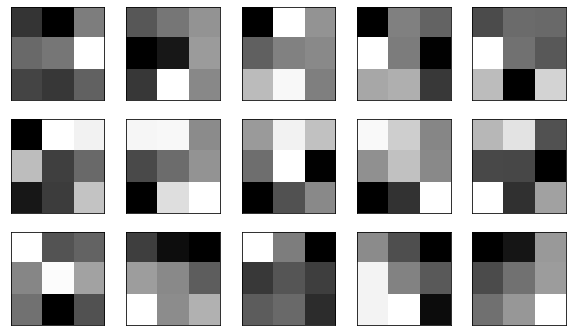

In [8]:
# Show filter matrix
n_filters, ix = 5, 1
plt.figure(figsize=(10, 10))
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 5, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
        # show the figure
plt.show()

In [34]:
# Predict random image (not in training or testing)
size = [300, 400]
img = Image.open(os.path.realpath('../Project/data/images/2020-01-16/66_093911_1_6.png'))
img = img.resize((size[1], size[0]), Image.ANTIALIAS)
img_t = np.array(img, dtype='uint8')
img_t = img_t.reshape(-1, size[0], size[1], 1)
test_img = model.predict(img_t)
img_pred = test_img.argmax(axis=1).astype(int)
print('The predicted defect is number: ', defect_dict[int(img_pred)])


The predicted defect is:  76


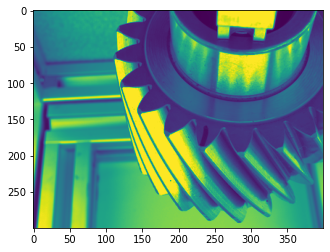

In [35]:
# Show img
plt.imshow(img)

In [38]:
# Create new filter model to convolve image
num = 3
filter_model = Model(inputs=model.inputs, outputs=model.layers[num].output)
filters, biases = model.layers[num].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

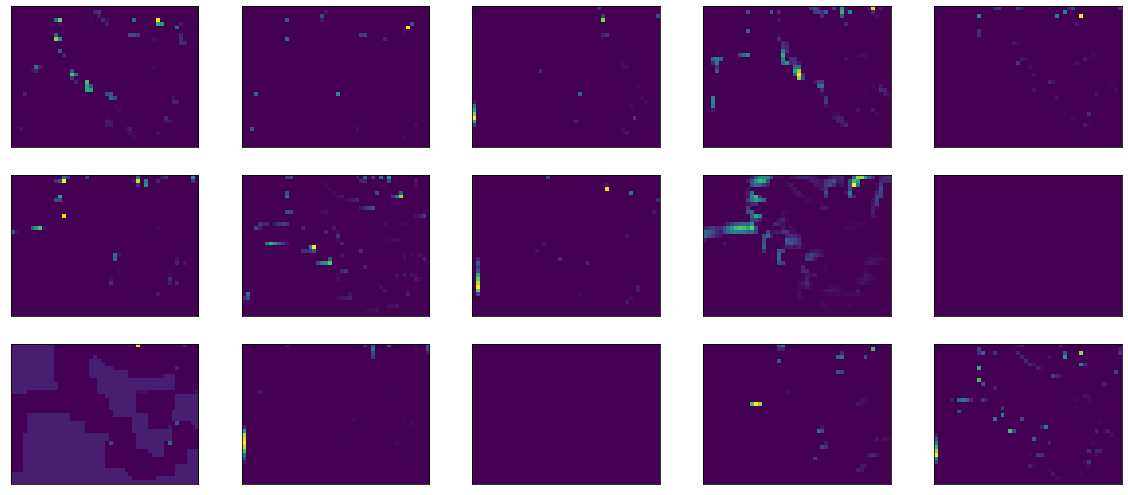

In [39]:
# Show convolved image through a specific filter layer

feature_map = filter_model.predict(img_t)
n_filters, ix = 5, 1
plt.figure(figsize=(20, 15))
for i in range(n_filters):
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 5, ix)
        ax.set_xticks([])
        ax.set_yticks([])

        # plot filter channel in grayscale
        plt.imshow(feature_map[0, :, :, ix-1])
        ix += 1
        # show the figure
plt.show()

In [42]:
# Create multiple filter layer
# Extracts the outputs of the top 12 layers
layer_outputs = [layer.output for layer in model.layers[:12]] 
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
activations = activation_model.predict(img_t)
 

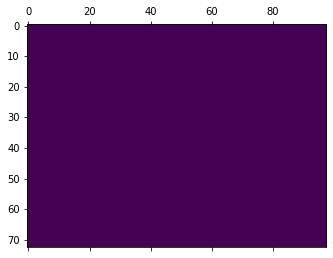

In [43]:
# Single filter output
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

<ipython-input-44-a83b9d3c2ecf>:26: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


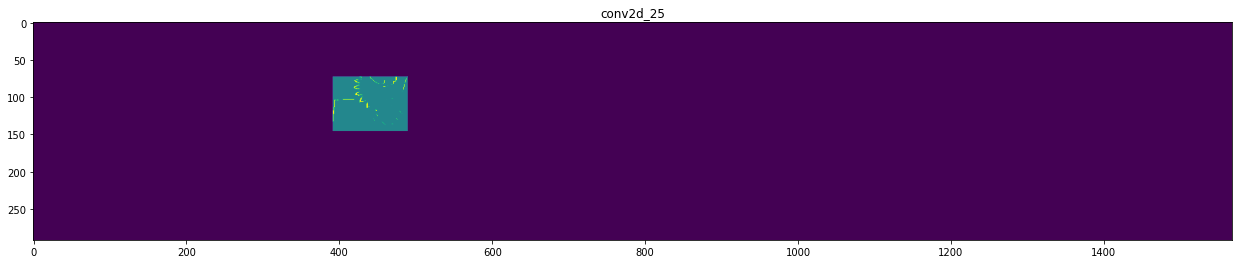

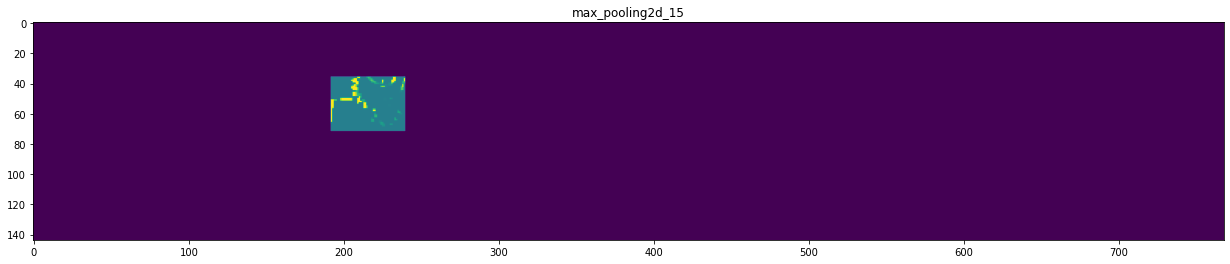

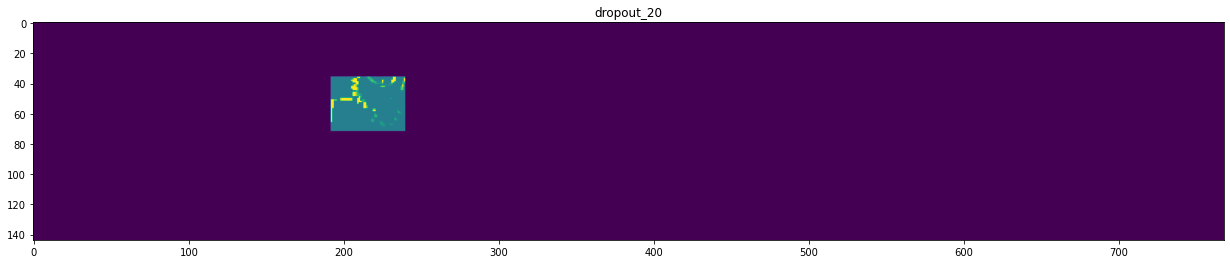

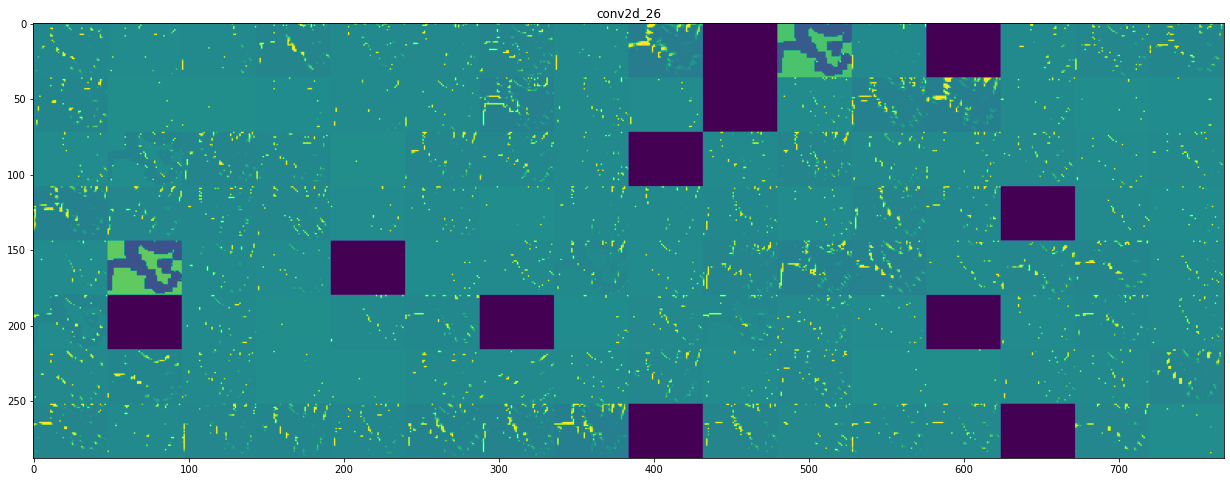

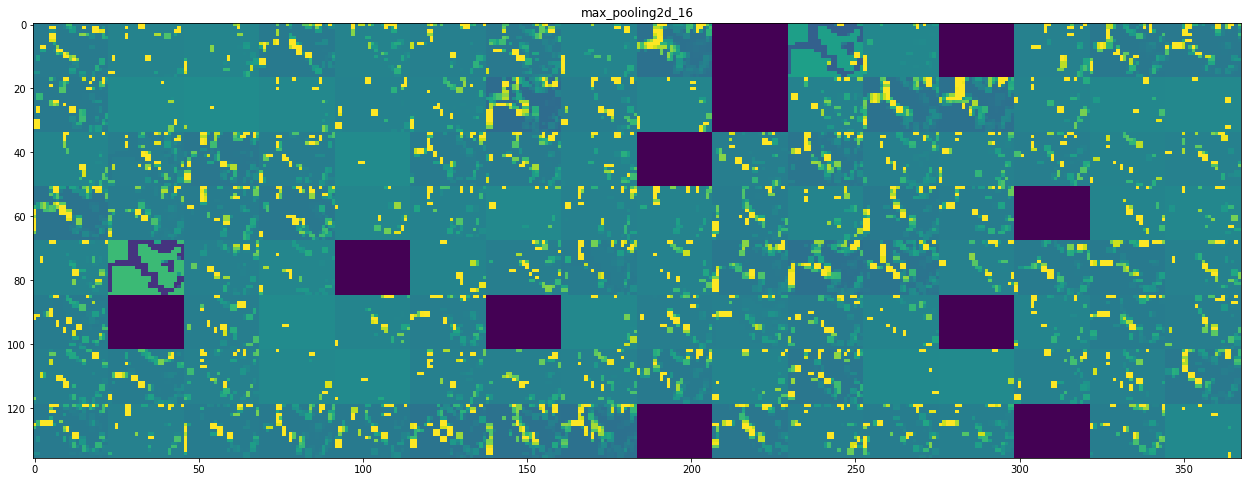

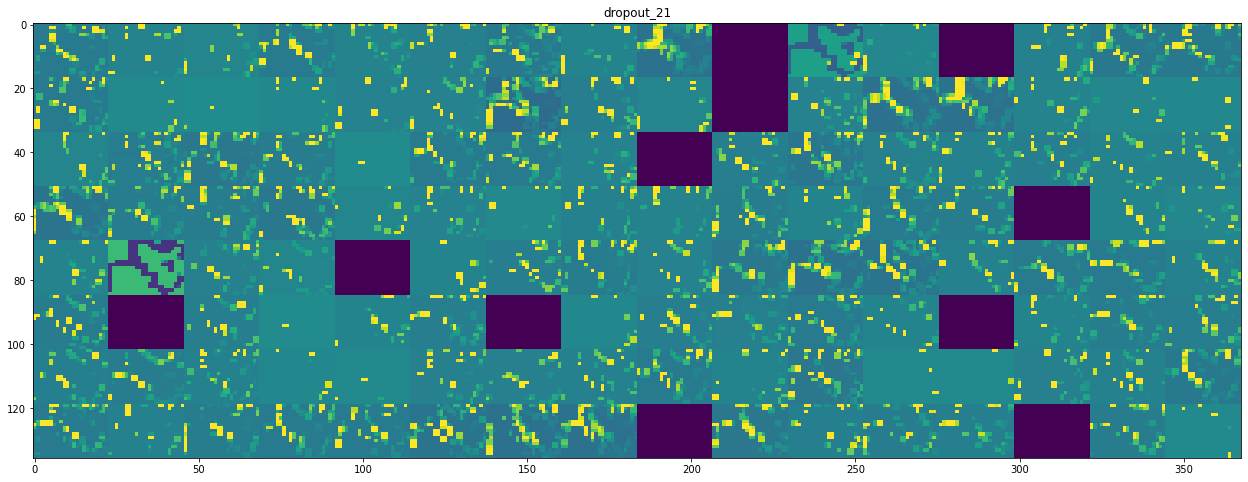

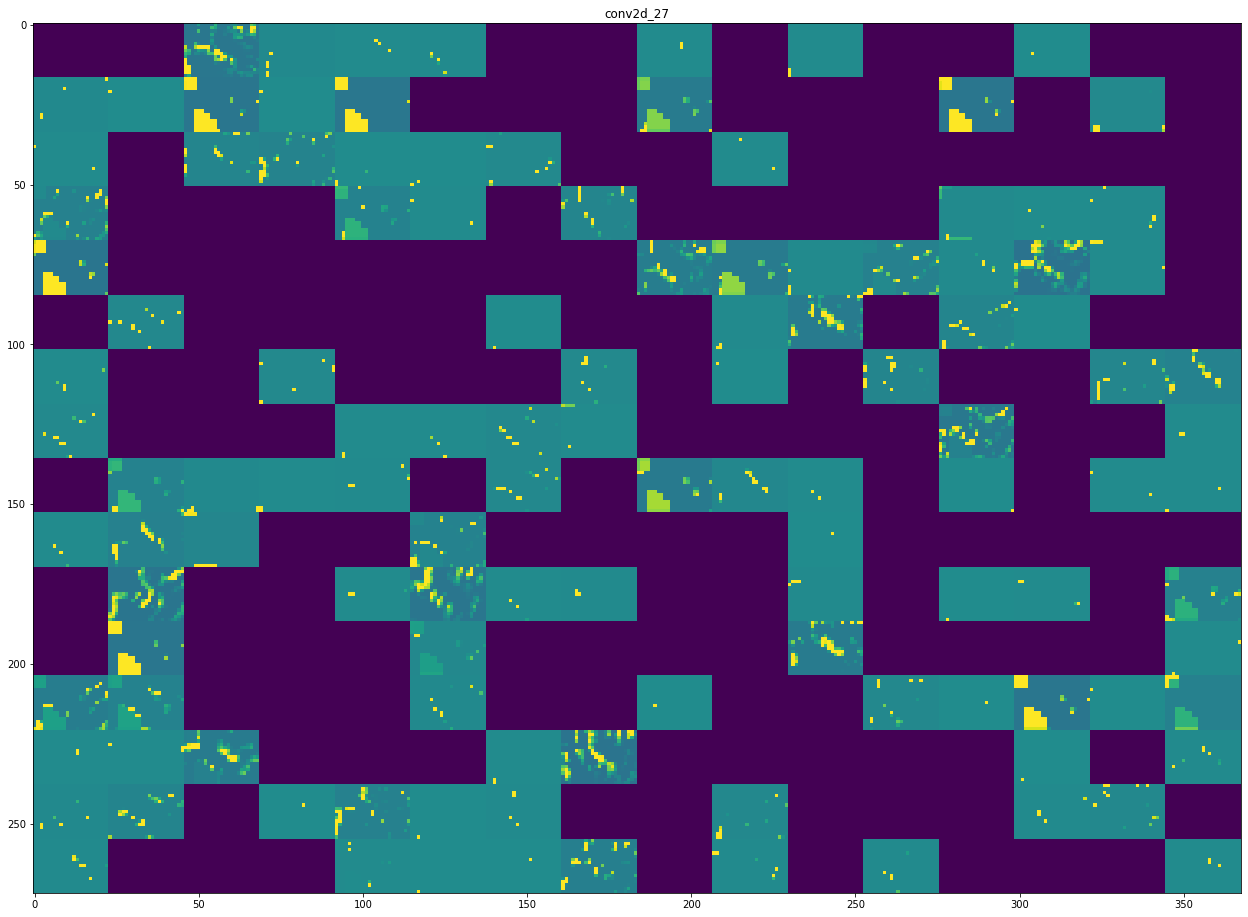

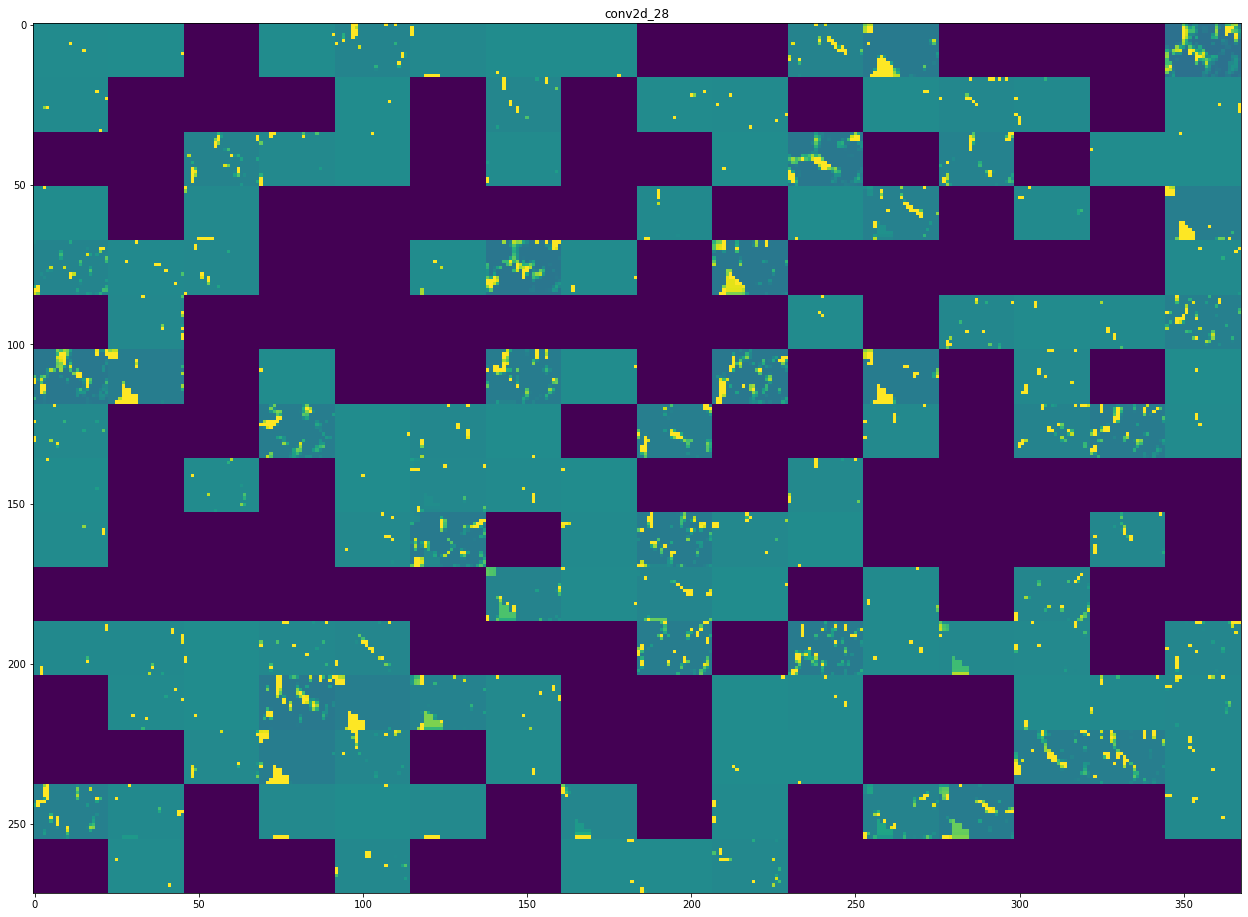

In [44]:
## Show all feature map outputs of each convolved filter
layer_names = []
for layer in model.layers[:8]:
    # Names of the layers
    layer_names.append(layer.name) 
    
images_per_row = 16
# Displays the feature maps
for layer_name, layer_activation in zip(layer_names, activations): 
    # Number of features in the feature map
    n_features = layer_activation.shape[-1] 
    # The feature map has shape (1, size, size, n_features).
    size_layer_col = layer_activation.shape[1] 
    size_layer_row = layer_activation.shape[2] 
    # Tiles the activation channels in this matrix
    n_cols = n_features // images_per_row 
    display_grid = np.zeros((size_layer_col * n_cols, images_per_row * size_layer_row))
    # Tiles each filter into a big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-processes the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            # Displays the grid
            display_grid[col * size_layer_col : (col + 1) * size_layer_col,
                         row * size_layer_row : (row + 1) * size_layer_row] = channel_image
    scale = 1. / size_layer_col
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto')